<a href="https://colab.research.google.com/github/KemasRaihan/DetectingLungCancer/blob/main/Detect_lung_cancer_using_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Lung Cancer From CT Images Using Neural Networks

# Abstract

This projects involves the use of computer vision which teaches computers to interpret and make decisions based on visual data. In healthcare, computer vision algorithms are taught to recognise patterns and irregularities in medical images that are suggestive of malignant growths in the context of lung cancer diagnosis.

# Introduction

**Computer Vision In Lung Cancer Detection**

Lung cancer is one of the leading causes of cancer-related fatalities globally, motivating the crucial need of early and precise detection. Fortunately, the use of medial images such as X-rays and Computed Tomography (CT) gives comprehensive cross-sectional pictures of the lungs, making it an important tool for identifying lung cancer. Traditional methods of analysis have heavily relied on radiologists' skill, prompting the the development of automated solutions by using machine learning algorithms.

**Experiment Design**

In this project, I will use several methods to build neural network algorithms to detect lung cancer from CT images. I will build and use a convolutional neural network (CNN) by fine-tuning its hyperparameters. Then  I will train two pre-trained models (ResNet50V2 and InceptionV3) by transfer learning.  I will analyse my dataset to make any predictions on the results. Then I will ulitilise these algorithms to create sophisticated image classification systems that can effectively identify lung cancer patterns in CT scans. All of the models will be trained using a huge dataset of annotated lung pictures to discover different characteristics indicative of lung cancer occurrence. After training, I will use the test dataset to make the model prediction on the class of the image. Then I will use confusion matrices along with a classification report to evaluate, compare and contrast the models that I have created.

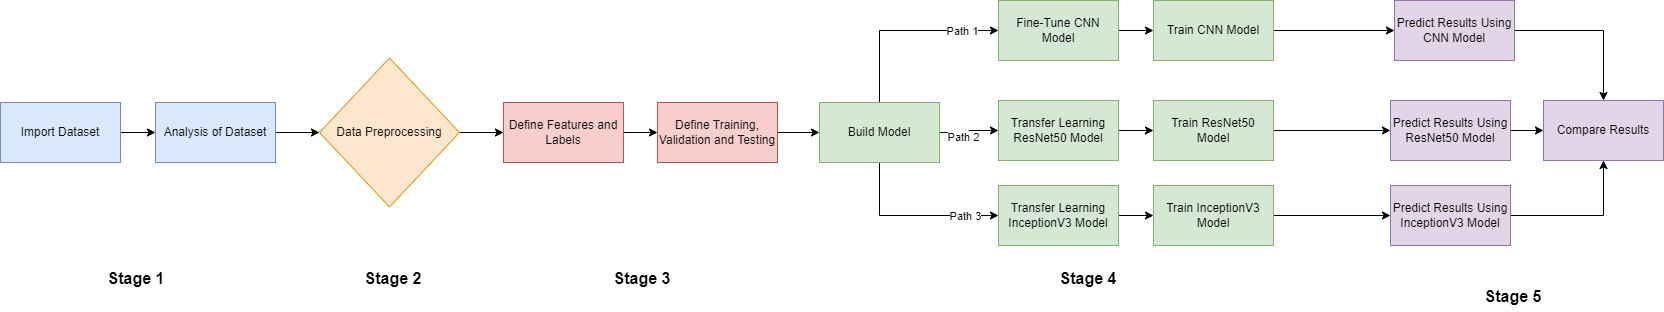

**Figure 1** - Experiment design path







**Libraries Used**

I will use the cv2, os and itertools libraries for reading and importing my medical images. The PIL, matplotlib, pandas and numpy libraries for extracting images. The tensorflow libraries for building my neural networks. The sklearn library for training, testing and validation and to create the classification reports. The time library for recording the length of time of training for each model. The seaborn library to display my confusion matrices.

In [ ]:
# For reading and import medical images
import cv2
import os
from itertools import chain

# For creating graphs and extracting images
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# For building the neural networks
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, SimpleRNN, BatchNormalization
from keras.utils import plot_model

# For fine-tuning parameters in our neural networks
!pip install keras-tuner -q
import keras_tuner
from keras.preprocessing.image import ImageDataGenerator
from kerastuner.engine.hyperparameters import HyperParameter

# For training, testing and validation
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random

# For recording the time for training
import time

# For evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

**RAM Issues**

Due to limitations of the machine, I can only train the models on a small subset of the dataset and for fewer epochs. This is why in this Google Colab notebook, the models are only trained using 40 images and 20 epochs, since I only want to demonstrate that the python code still works and they produce graphs, confusion matrices and classification reports. However, it is important to note that these results provide a rough estimate of predictions. If I had the capacity to train on more samples and for additional epochs, the predictions could potentially be more accurate. Although, we will still evaluate the methods that we have used based on the research I have done.

# 1. Lung Cancer CT Raw Image Dataset Analysis

**1.1 Import Dataset**

For our dataset we will use high-quality CT scan images from patients with confirmed lung cancer and healthy individuals which we will collect for training, testing and validation purposes. This dataset will be extracted from the [Kaggle](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images) website.


This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas).

In [ ]:
# Define directory path
path = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Artificial Intelligence and Machine Learning 2/DetectingLungCancer/lung_colon_image_set/lung_image_sets'

# Load classes through output stream
classes = os.listdir(path)

# Define class labels
class_names = ['Benign', 'Aden', 'SCC']

**1.2 Lung CT Image Classes**

Benign lung tissues are non-cancerous tissues. Adenocarcinomas start in the cells that would normally secrete substances such as mucus. This type of lung cancer occurs mainly in people who smoke or used to smoke, but it is also the most common type of lung cancer seen in people who don't smoke. Squamous cell carcinomas start in squamous cells, which are flat cells that line the inside of the airways in the lungs. They are often linked to a history of smoking and tend to be found in the central part of the lungs, near a main airway (bronchus) (American Cancer Society, January 12, 2023).

In [ ]:
# Iterate over each class in the 'classes' list
for i, class_ in enumerate(classes):
    # Form the directory path for the images of the current class
    image_dir = f'{path}/{class_}'

    # List all images in the specified directory
    images = os.listdir(image_dir)

    # Create a subplot with 1 row and 3 columns, set the overall figure size
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Set the main title for the figure
    fig.suptitle(f'Images for Lung {class_names[i]} set')

    # Display the first three images for the current class
    for i in range(3):

      # Generate random index
      k = np.random.randint(0, len(images))

      # Read a randomly selected image and convert it to a NumPy array
      img = np.array(Image.open(f'{path}/{class_}/{images[k]}'))

      # Display the image in the i-th subplot
      ax[i].imshow(img)

      # Turn off axis labels for better visualization
      ax[i].axis('off')

    # Show the current figure with the three images
    plt.show()

**Figure 2** - Images from the benign, adenocarcinomas and squamous cell carcinomas image sets.

**1.3 Import Dataset**

During the import dataset process, the images will be split into four different tiles to accomodate the RAM issue. The tiles will be appended into an empty list. Their corresponding labels will be appended into a separate array which we will define later on.

In [ ]:
# Split image into different tiles
def split_image(image, num_of_tiles):
  # Split image into MxN pixels
  M = image.shape[0] // (num_of_tiles // 2)
  N = image.shape[1] // (num_of_tiles // 2)

  # Splitting image to tiles of MxN pixels
  tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
  return tiles

In [ ]:
def load_images(path, classes, num_images_per_class):
    # Initialize empty lists to store images and labels
    images = []
    labels = []

    # Iterate over classes using enumerate to get both index (i) and class name (class_)
    for i, class_ in enumerate(classes):
        # For every image in the class folder, append to the images_set array
        images_set = []
        # Create the folder path for the current class
        folder = os.path.join(path, class_)

        # List all files in the folder (assuming they are images)
        files = os.listdir(folder)

        # Retrieve a specified number of images per class
        image_files = files[:num_images_per_class]

        # Iterate over each file in the folder
        for file in image_files:
            # Create the full path for the current image file
            file_path = os.path.join(folder, file)

            # Read the image using OpenCV
            image = cv2.imread(file_path)

            # Check if the image is not None
            if image is not None:
                # Split image into 4 tiles
                tiles = split_image(image, 4)

                # Append every image in tiles to the X list
                images_set.extend(tiles)

                # Append the label to the y list
                labels.extend([i] * len(tiles))

        # Append images array to dataset
        images.append(images_set)

        # Append the label to

    return images, labels

In [ ]:
# Change number of images per class in order to adjust for RAM performance
num_images_per_class = 40

# Define images and labels
images, labels = load_images(path, classes, num_images_per_class)

In [ ]:
# Define images as numpy array for further processing
image_arr = np.asarray(images)

# Print shape of images
print(image_arr.shape)

(3, 160, 384, 384, 3)


In [ ]:
# Define benign lung image set
benign_images = image_arr[0]

# Define adenocarcinomas lung images set
aden_images = image_arr[1]

# Define squamous cell carcinomas lung image set
scc_images = image_arr[2]

**1.4 Data Distribution**

We will examine the data disribution of the pixel values of each class dataset to determine how well our models will predict each image.

In [ ]:
# Define images as dictionary of each different classes
image_dict = {'benign' : benign_images,
          'aden' : aden_images,
          'scc' : scc_images}

In [ ]:
# Calculate mean of pixel values for benign image set
mean_pos_benign = np.mean(image_dict['benign'].flatten())

# Calculate standard deviation of pixel values for benign image set
std_pos_benign = np.std(image_dict['benign'].flatten())

# Calculate mean of pixel values for Adenocarcinomas set
mean_pos_aden = np.mean(image_dict['aden'].flatten())

# Calculate standard deviation of pixel values for Adenocarcinomas set
std_pos_aden = np.std(image_dict['aden'].flatten())

# Calculate mean of pixel values for Squamous cell carcinomas set
mean_pos_scc = np.mean(image_dict['scc'].flatten())

# Calculate standard deviation of pixel values for Squamous cell carcinomas set
std_pos_scc = np.std(image_dict['scc'].flatten())

In [ ]:
# Define the model names and their scores for both training and validation set
classes = {'Benign' : {'mean' : mean_pos_benign,
                       'std' : std_pos_benign
                   },
           'Aden' : {'mean' : mean_pos_aden,
                       'std' : std_pos_aden
                   },
           'SCC' : {'mean' : mean_pos_scc,
                       'std' : std_pos_scc
                   }
          }
#Create a dataframe table of the dictionary of the models
scores = pd.DataFrame(classes).T
scores

,mean,std
Benign,172.483038,58.599380
Aden,164.986543,57.348265
SCC,184.836931,41.834525


**Table 1** - The mean and standard deviation of the benign, adenocarcinomas and squamous cell image datasets.

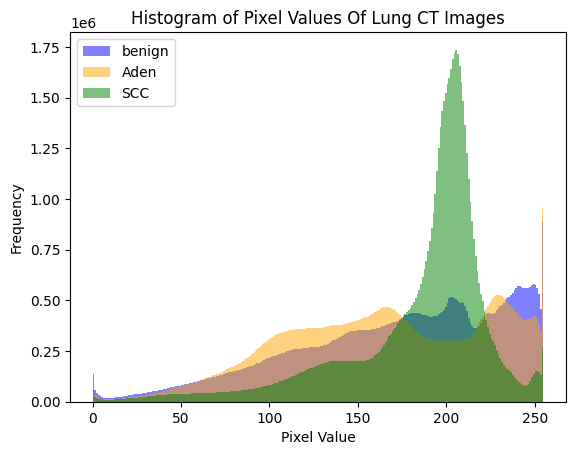

In [ ]:
# Plot histogram for pixel values of benign lung images
plt.hist(benign_images.flatten(), bins=256, range=(0, 255), color='blue', alpha=0.5, label='benign')

# Plot histogram for pixel values of Adenocarcinomas images
plt.hist(aden_images.flatten(), bins=256, range=(0, 255), color='orange', alpha=0.5, label='Aden')

# Plot histogram for pixel values of Squamous cell carcinomas images
plt.hist(scc_images.flatten(), bins=256, range=(0, 255), color='green', alpha=0.5, label='SCC')

# Set the title of the plot
plt.title('Histogram of Pixel Values Of Lung CT Images')

# Set the label for the x-axis
plt.xlabel('Pixel Value')

# Set the label for the y-axis
plt.ylabel('Frequency')

# Add a legend to the plot to distinguish between different image sets
plt.legend()

# Display the plot
plt.show()

**Figure 3** - From table 1 and the histograms, the pixel values for the Benign and Adenocarcinomas images are evenly distributed, while Squamous cell carcinomas images are more negatively skewed where the mean is higher with a lower standard deviation. This suggests strongly that lighter colours are much more prevalent in the images. This suggest that lighter CT images of lungs could indicate a present of lung cancer abnormalities. Furtheremore, from the images displayed, this would mean that neural networks that detect lighter and smoother surfaces would make more accurate predictions.

# 2. Data Preprocessing

Image preprocessing is the initial step we have to take before training our model. Pre-processing will allow the neural networks to produce more accurate results.

In [ ]:
# Resize the image to the specified dimensions
def resize(image, img_size):
  return cv2.resize(image, (img_size, img_size))

In [ ]:
 # Normalize pixel values to the range [0, 1]
def normalise(image):
  return image / 255.0

In [ ]:
# Function to load and preprocess images
def preprocess_image(image, img_size):
  # Resize the image to the specified dimensions
  image = resize(image, img_size)

  # Normalize pixel values to the range [0, 1]
  image = image / 255.0

  return image

In [ ]:
# Change image size
img_size = 256

In [ ]:
def preprocess_each_image(images, img_size=256):
  # Initialise array to store preprocessed images
  preprocessed_images = []

  # Preprocess each image
  for i in range(len(images)):
     preprocessed_images.append(preprocess_image(images[i], img_size))

  # Convert to numpy arrays for further processing and analysis
  preprocessed_images = np.asarray(preprocessed_images)

  return preprocessed_images

In [ ]:
# Preprocess each benign image
benign_images_preprocessed = preprocess_each_image(benign_images, img_size)

# Preprocess each aden image
aden_images_preprocessed = preprocess_each_image(aden_images, img_size)

# Preprocess each scc image in X
scc_images_preprocessed = preprocess_each_image(scc_images, img_size)

In [ ]:
print(benign_images_preprocessed.shape)

(160, 256, 256, 3)


# 3. Define Training, Testing and Validation Set

**3.1 Define features (X)**

Define the image feature space matrix as our features`X`
which can predict soft probabilities of an image being from each class with the highest probability for the class to which it really belongs.

In [ ]:
# Concatenate each different class image sets and define it as X
X = np.concatenate((benign_images_preprocessed, aden_images_preprocessed, scc_images_preprocessed), axis=0)

**3.2 Define labels (y)**

Define the one hot encoding of `labels` as `y`. This will help us to train a model which can predict soft probabilities of an image being from each class with the highest probability for the class to which it really belongs. Under this encoding, each class label has its own separate registers bits and only one of them is valid. This allows the fair losses of different types of errors and solves that numerical labels are difficult to optimise (Čačak, Serbia 2019).

In [ ]:
# Get dummy values from labels to define y
y = pd.get_dummies(labels).values

In [ ]:
print(X.shape)

(480, 256, 256, 3)


**3.3 Define training, testing and validation set**

In [ ]:
# Firstly split them into the training dataset and the rest as remaining dataset for validation and testing
X_train, X_rem, y_train, y_rem = train_test_split(X, y , train_size=0.8, random_state=42)

# Split the remaining dataset for validation and testing
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size=0.5)

# Print X_train shape, X_valid shape and X_test shape
print(f'X_train shape:{X_train.shape} \nX_valid shape:{X_valid.shape} \nX_test shape:{X_test.shape}')

X_train shape:(384, 256, 256, 3) 
X_valid shape:(48, 256, 256, 3) 
X_test shape:(48, 256, 256, 3)


# 4. Building and Training The Models

## Convolutional Neural Networks Fine-Tuning

**4.1 Convolutional Neural Networks In Image Classification**

In this chapter, I will fine-tune a convolutional neural network (CNN) algorithm to find the best hyperparameters to optimise the model's performance. Then I will utilise it to create a sophisticated image classification system that can effectively identify lung cancer patterns in X-rays and CT scans. The model will be trained using the dataset to discover different characteristics indicative of lung cancer occurrence.

**4.1.1 Build CNN Model By Fine-Tuning**

I will build a CNN model by fine-tuning the number of convolutional 2D layers it has. In each layer, I will fine-tune the number of filters, the kernel size, and its activation function. I will also fine-tune the learning rate of the optimizer.



In [ ]:
def build_model(hp):
  #Define the search space
  model = Sequential()

  # Define Convolutional Layer with the input shape '[[IMG_SIZE, IMG_SIZE, 3]]' with IMG_SIZE
  # corresponding to the image size and 3 with the RGB channels
  model.add(Conv2D(filters=32, kernel_size=(5,5),activation='relu',input_shape=[img_size, img_size, 3],padding='same')),

  # Check if the spatial dimensions are greater than 2 before adding max pooling
  if model.output_shape[1] > 2 and model.output_shape[2] > 2:
    model.add(MaxPooling2D(2, 2))

  # Find the best number of layers
  for i in range(hp.Int("layers", 4, 10)):
    # Define Convolutional Layer with the input shape with the best hyper parameters
    model.add(Conv2D(
        filters=hp.Choice('filters', [32,64,128,256]),
        kernel_size=(hp.Choice('kernel_size_1', [3, 4, 5]), hp.Choice('kernel_size_2', [3, 4, 5])),
        activation=hp.Choice('activation',['relu','tanh']),
        padding='same'))

    # Check if the spatial dimensions are greater than 2 before adding max pooling
    if model.output_shape[1] > 2 and model.output_shape[2] > 2:
      model.add(MaxPooling2D(2, 2))

  # Flatten layer to convert 3D feature maps to 1D feature vectors
  model.add(Flatten())

  # Fully Connected Layer with 256 neurons and ReLU activation function
  model.add(Dense(256, activation='relu'))

  # Batch Normalization layer to normalize and stabilize the training process
  model.add(BatchNormalization())

  # Fully Connected Layer with 128 neurons and ReLU activation function
  model.add(Dense(128, activation='relu'))

  # Dropout layer to prevent overfitting by randomly setting a fraction of input units to zero during training
  model.add(Dropout(0.3))

  # Batch Normalization layer to normalize and stabilize the training process
  model.add(BatchNormalization())

  # Output Layer with 3 neurons (assuming a classification task) and softmax activation function
  model.add(Dense(3, activation='softmax'))

  # Compile Model Using
  model.compile(
      optimizer=keras.optimizers.Adam(
          learning_rate=hp.Float('lr',min_value=1e-4,max_value=1e-2,sampling='log')),
      loss='categorical_crossentropy',
      metrics=['accuracy']
      )
  return model

build_model(keras_tuner.HyperParameters())

In [ ]:
MAX_TRIALS = 3
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=MAX_TRIALS)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
# Initialise time
t0 = time.time()

# Fine best model
EPOCHS = 20
tuner.search(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid))
CNN_model = tuner.get_best_models()[0]

# Record time
CNN_training_time = time.time()-t0
print("Training time:", time.time()-t0)

Training time: 1.224128007888794


**4.1.2 Summary Of CNN Model**

In [ ]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     82048     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       327808    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

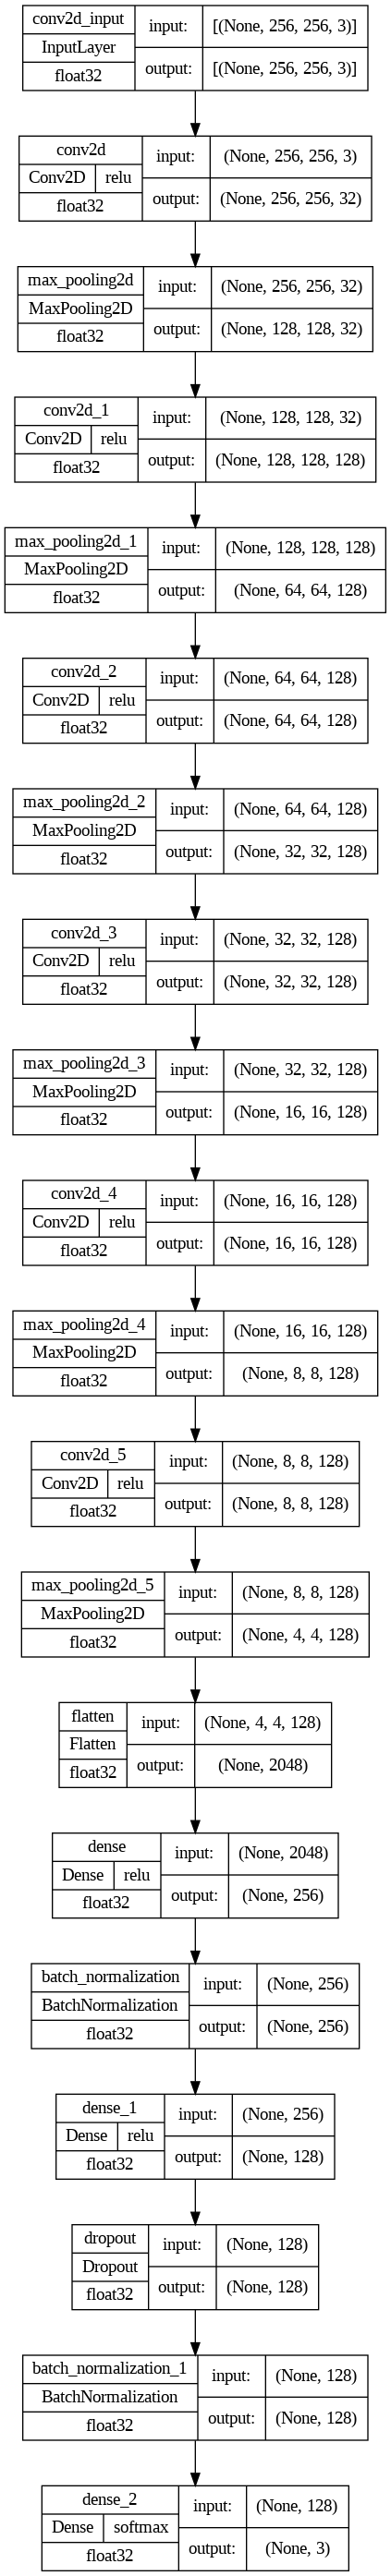

In [ ]:
plot_model(
    CNN_model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

**Figure 4** - Layers of the fine-tuned CNN model.

**4.1.3 Save/Load CNN Model**

In [ ]:
# Define file path to save/load CNN model
filepath_CNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Artificial Intelligence and Machine Learning 2/DetectingLungCancer/CNN_LungCancer_Detection.keras'

In [ ]:
# save CNN model
keras.saving.save_model(CNN_model, filepath_CNN)

In [ ]:
# load CNN model
CNN_model = tf.keras.saving.load_model(
    filepath_CNN, custom_objects=None, compile=True
)

## ResNet50 Transfer Learning

**4.2 Transfer Learning From ResNet50 Using Keras**

Training large-scale image models is time and energy-consuming. As most vision datasets have some common features, it is possible to take a network trained on a similar dataset and use the trained features to reduce training time on a different dataset. Transfer learning is a technique in which an existing model trained on one problem is utilised on another related problem. In this case, I will using the pre-trained model to identify lung cancer in my dataset.

**4.2.1 ResNet50**

ResNet is a type of CNN introduced in the 2015 publication "Deep Residual Learning for Image Recognition" by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. ResNet-50 is a convolutional neural network of 50 layers (48 convolutional layers, 1 MaxPool layer, and 1 average pool layer). Residual neural networks (RNNs) are artificial neural networks (ANNs) that build networks by stacking residual blocks (Datagen n.d.).

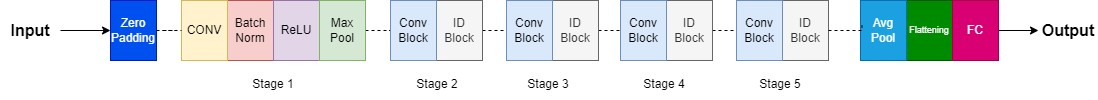

**Figure 5** - ResNet50 Architecture taken from Mukherjee, S. (2022, August 18).

The 50-layer ResNet architecture includes the following layers:

*   A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride.
*   A max pooling layer with a 2-sized stride.
*   9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times.
*   12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times.
*   18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times.
*   9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.

(up to this point the network has 50 layers)

Average pooling, followed by a fully connected layer with 1000 nodes, using the softmax activation function.


**4.2.2 ResNet50V2**

ResNet50V2 is an modified and improved version of the ResNet50, where a modification was made in the propagation formulation of the connections between blocks. ResNet50V2 also provides a good result on the ImageNet dataset.(He, K., Zhang, X., Ren, S., & Sun, J. 2016).

In [ ]:
# Load pre-trained ResNet model from Keras
base_model = keras.applications.resnet_v2.ResNet50V2(
    input_shape = (img_size, img_size, 3),
    weights = 'imagenet',
    include_top = False
)

**4.2.3 Pre-processing Dataset For ResNet Model**

The input data format, data type, and structure (Tensorflow data structure) should match the prebuild model, therefore I will integrate it using the Keras function `keras.applications.resnet50.preprocess_input()` which preprocesses a tensor encoding a batch of images (TensorFlow v2.11.0. n.d.).

In [ ]:
def preprocessing(X):
  return keras.applications.resnet50.preprocess_input(X)

In [ ]:
# Pre-process training dataset
X_train = preprocessing(X_train)

# Pre-process validation dataset
X_valid = preprocessing(X_valid)

# Pre-process testing dataset
X_test = preprocessing(X_test)

# Print X_train shape, X_valid shape and X_test shape
print(f'X_train shape:{X_train.shape} \nX_valid shape:{X_valid.shape} \nX_test shape:{X_test.shape}')

X_train shape:(384, 256, 256, 3) 
X_valid shape:(48, 256, 256, 3) 
X_test shape:(48, 256, 256, 3)


**4.2.4 Freeze the layers**

I will take the layers from, the previously trained model, and freeze them, so as to avoid destroying any of the information they contain during future training rounds..

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

**4.2.5 Create the final model**

I will add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset (Team, K. 2020, April 15).

In [ ]:
# Create a new ResNet model
ResNet50V2_model = Sequential()

# Add the pre-trained ResNet50 base model (excluding the top layers)
ResNet50V2_model.add(base_model)

# Flatten the output of the base model before feeding it to the fully connected layers
ResNet50V2_model.add(Flatten())

# Add a densely connected layer with 256 neurons and ReLU activation function
ResNet50V2_model.add(Dense(256, activation='relu'))

# Add Batch Normalization to normalize the activations and improve training stability
ResNet50V2_model.add(BatchNormalization())

# Add another densely connected layer with 128 neurons and ReLU activation function
ResNet50V2_model.add(Dense(128, activation='relu'))

# Add Dropout layer with a rate of 0.3 to prevent overfitting
ResNet50V2_model.add(Dropout(0.3))

# Add Batch Normalization after Dropout for improved stability
ResNet50V2_model.add(BatchNormalization())

# Add the final output layer with 3 neurons (assuming 3 classes for lung cancer) and softmax activation
ResNet50V2_model.add(Dense(3, activation='softmax'))

**4.2.6 Compile the ResNet model**

In [ ]:
# Define optimiser for ResNet50V2 model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile ResNet50V2 model
ResNet50V2_model.compile(loss='categorical_crossentropy',optimizer=optimiser, metrics=['accuracy'])

**4.2.7 Summary of the ResNet model**

In [ ]:
ResNet50V2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               33554688  
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

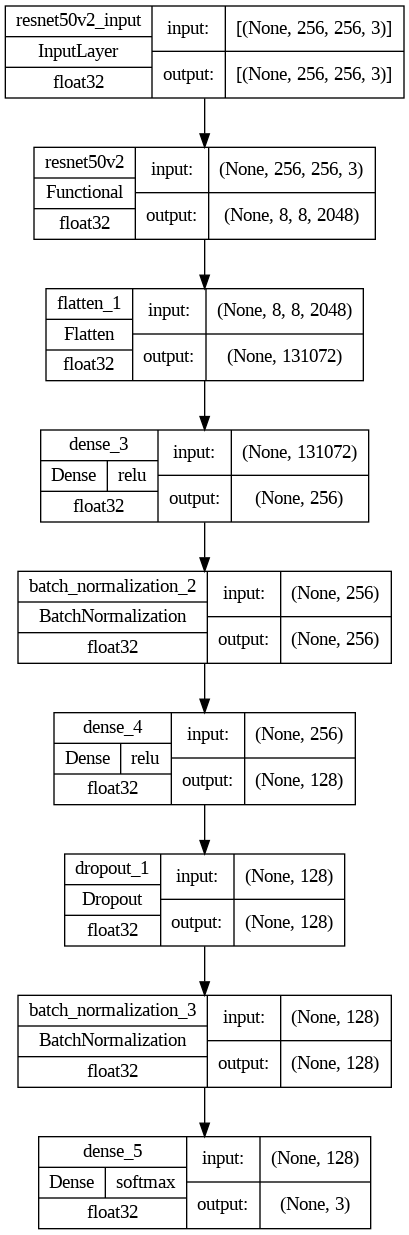

In [ ]:
plot_model(
    ResNet50V2_model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

**Figure 6** - Layers of the ResNetV2 model.

**4.2.8 Train the ResNetV2 model**

In [ ]:
# Initialise time
t0 = time.time()

# Train ResNet50V2 Model
ResNet50V2_history = ResNet50V2_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid))

# Record time
ResNet50V2_training_time = time.time()-t0
print("Training time:", time.time()-t0)

Epoch 1/20
12/12 [==============================] - 6s 247ms/step - loss: 0.9772 - accuracy: 0.5859 - val_loss: 1553.3356 - val_accuracy: 0.2292
Epoch 2/20
12/12 [==============================] - 2s 153ms/step - loss: 0.5901 - accuracy: 0.7578 - val_loss: 1068.9735 - val_accuracy: 0.2292
Epoch 3/20
12/12 [==============================] - 2s 156ms/step - loss: 0.5503 - accuracy: 0.7734 - val_loss: 473.7596 - val_accuracy: 0.2292
Epoch 4/20
12/12 [==============================] - 2s 158ms/step - loss: 0.4701 - accuracy: 0.8177 - val_loss: 364.3827 - val_accuracy: 0.2292
Epoch 5/20
12/12 [==============================] - 2s 154ms/step - loss: 0.4704 - accuracy: 0.8073 - val_loss: 116.1596 - val_accuracy: 0.3958
Epoch 6/20
12/12 [==============================] - 2s 139ms/step - loss: 0.4367 - accuracy: 0.8229 - val_loss: 66.7852 - val_accuracy: 0.3750
Epoch 7/20
12/12 [==============================] - 2s 140ms/step - loss: 0.3798 - accuracy: 0.8620 - val_loss: 294.7198 - val_accuracy

**4.2.9 Visualise Training History Of ResNetV2**

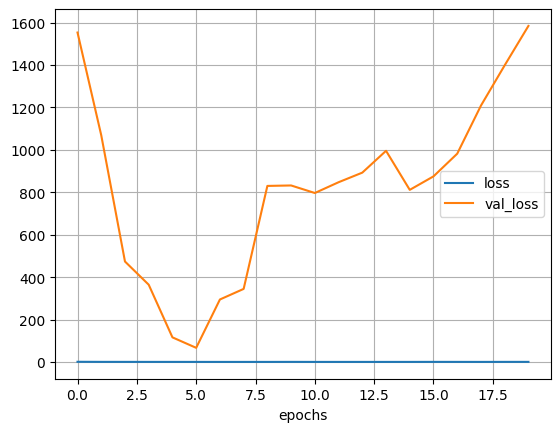

In [ ]:
history_df = pd.DataFrame(ResNet50V2_history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.xlabel('epochs')
plt.grid()
plt.show()

**Figure 7** - Loss history during ResNet50V2 training.

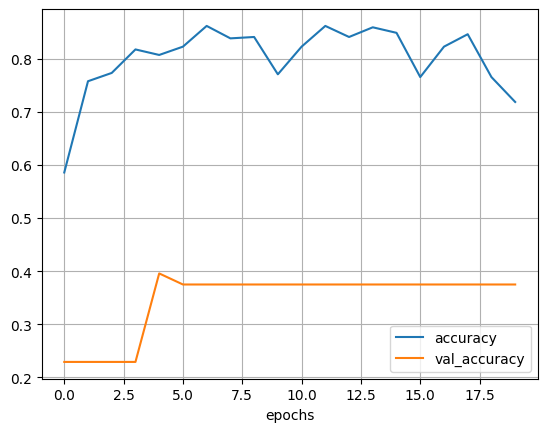

In [ ]:
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.xlabel('epochs')
plt.grid()
plt.show()

**Figure 8** - Accuracy history during ResNet50V2 training.

**4.2.10 Save/Load RNN model**

In [ ]:
# Define filepath for ResNet50V2 model
filepath_ResNet50V2 = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Artificial Intelligence and Machine Learning 2/DetectingLungCancer/ResNet_LungCancer_Detection.keras'

In [ ]:
# save trained ResNet model
keras.saving.save_model(ResNet50V2_model, filepath_ResNet50V2)

In [ ]:
# load trained ResNet model
ResNe50V2_model = tf.keras.saving.load_model(
    filepath_ResNet50V2, custom_objects=None, compile=True
)

## InceptionV3 Transfer Learning

**4.3 Transfer Learning From InceptionV3 Using Keras**

**4.3.1 InceptionV1**

When numerous deep layers of convolutions were utilized in a model, the data was overfitted. To prevent this, the Inception V1 model employs the concept of using many filters of varying sizes on the same level. Thus, instead of having deep layers in the inception models, we have parallel layers, making our model wider rather than deeper. The Inception model is made up of multiple Inception modules. The basic module of the Inception V1 model is made up of four parallel layers:


*   1×1 convolution
*   3×3 convolution
*   5×5 convolution
*   3×3 max pooling



**4.3.2 InceptionV3**

The Inception V3 model is just the advanced and optimized version of the inception V1 model. The Inception V3 model used several techniques for optimizing the network for better model adaptation:

*   It has higher efficiency.
*   It has a deeper network compared to the Inception V1 and V2 models, but its speed isn't compromised.
*   Similarly to ResNet50, it comes with pre-trained weights. This is beneficial for transfer learning because it provides a starting point that increases convergence during training.

In [ ]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(
    input_shape = (img_size, img_size, 3),
    weights = 'imagenet',
    include_top = False
)

**4.3.3 Freeze the layers**

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

**4.3.4 Create the final model**

In [ ]:
# Create a Sequential model for transfer learning with InceptionV3
InceptionV3_model = Sequential()

# Add the pre-trained InceptionV3 base model (excluding the top layers)
InceptionV3_model.add(base_model)

# Flatten the output of the base model before feeding it to the fully connected layers
InceptionV3_model.add(Flatten())

# Add a densely connected layer with 256 neurons and ReLU activation function
InceptionV3_model.add(Dense(256, activation='relu'))

# Add Batch Normalization to normalize the activations and improve training stability
InceptionV3_model.add(BatchNormalization())

# Add another densely connected layer with 128 neurons and ReLU activation function
InceptionV3_model.add(Dense(128, activation='relu'))

# Add Dropout layer with a rate of 0.3 to prevent overfitting
InceptionV3_model.add(Dropout(0.3))

# Add Batch Normalization after Dropout for improved stability
InceptionV3_model.add(BatchNormalization())

# Add the final output layer with 3 neurons (3 classes for lung cancer) and softmax activation
InceptionV3_model.add(Dense(3, activation='softmax'))

**4.3.5 Compile the InceptionV3 model**

In [ ]:
# Compile InceptionV3 model
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

**4.3.6 Summary of the InceptionV3 model**

In [ ]:
InceptionV3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               18874624  
                                                                 
 batch_normalization_98 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

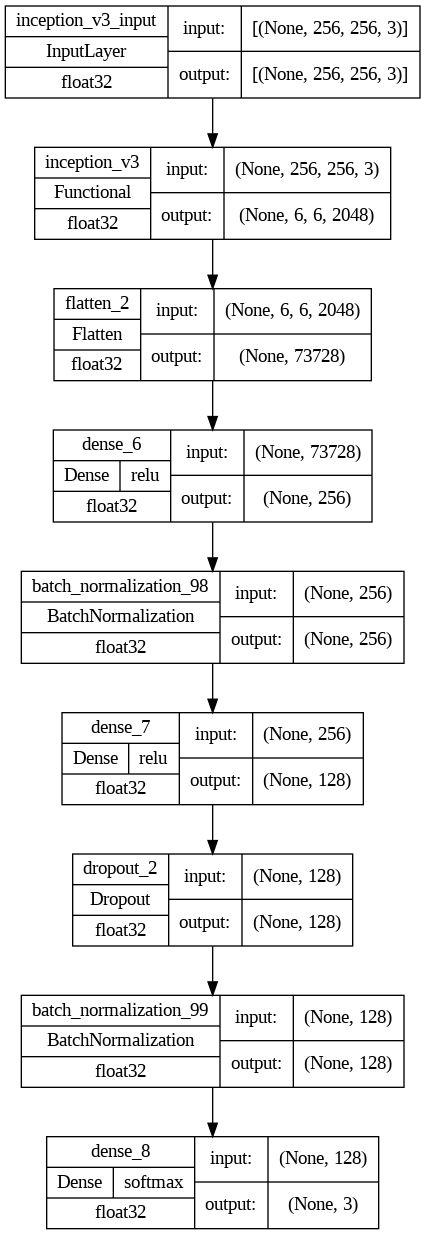

In [ ]:
plot_model(
    InceptionV3_model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

**Figure 9** - Layers of the InceptionV3 model.

**4.3.7 Train the InceptionV3 model**

In [ ]:
# Initialise time
t0 = time.time()

# Train the InceptionV3 model
InceptionV3_history = InceptionV3_model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid))

# Record final time for InceptionV3 model
InceptionV3_training_time = time.time()-t0
print("Training time:", time.time()-t0)

Epoch 1/20
12/12 [==============================] - 10s 323ms/step - loss: 0.8601 - accuracy: 0.6120 - val_loss: 1323.9991 - val_accuracy: 0.2292
Epoch 2/20
12/12 [==============================] - 1s 114ms/step - loss: 0.6739 - accuracy: 0.6979 - val_loss: 800.7010 - val_accuracy: 0.2292
Epoch 3/20
12/12 [==============================] - 1s 112ms/step - loss: 0.5533 - accuracy: 0.7422 - val_loss: 622.8707 - val_accuracy: 0.2292
Epoch 4/20
12/12 [==============================] - 1s 127ms/step - loss: 0.5096 - accuracy: 0.7734 - val_loss: 483.9215 - val_accuracy: 0.2292
Epoch 5/20
12/12 [==============================] - 1s 111ms/step - loss: 0.4577 - accuracy: 0.7917 - val_loss: 435.3411 - val_accuracy: 0.2292
Epoch 6/20
12/12 [==============================] - 1s 112ms/step - loss: 0.4669 - accuracy: 0.8125 - val_loss: 355.6136 - val_accuracy: 0.2292
Epoch 7/20
12/12 [==============================] - 1s 112ms/step - loss: 0.4518 - accuracy: 0.8021 - val_loss: 330.8056 - val_accurac

**4.3.8 Visualise Training History Of InceptionV3**

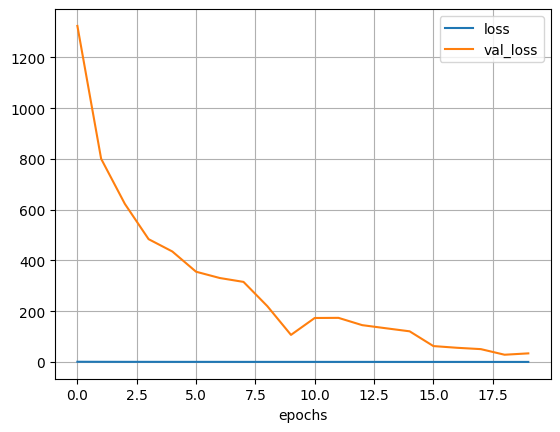

In [ ]:
history_df = pd.DataFrame(InceptionV3_history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.xlabel('epochs')
plt.grid()
plt.show()

**Figure 10** - Loss history during InceptionV3 training.

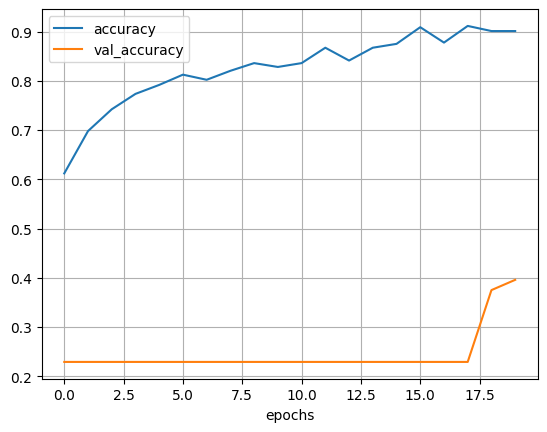

In [ ]:
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.xlabel('epochs')
plt.grid()
plt.show()

**Figure 11** - Accuracy history during InceptionV3 training.

**4.3.9 Save/Load InceptionV3 Model**

In [ ]:
# Define filepath to save/load InceptionV3 model
filepath_InceptionV3 = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Artificial Intelligence and Machine Learning 2/DetectingLungCancer/InceptionV3_LungCancer_Detection.keras'

In [ ]:
# Save trained InceptionV3 model
keras.saving.save_model(InceptionV3_model, filepath_InceptionV3)

In [ ]:
# Load trained InceptionV3 model
InceptionV3_model = tf.keras.saving.load_model(
    filepath_InceptionV3, custom_objects=None, compile=True
)

# 5. Evaluation

**5.1 Testing the Models**

For this part, we will test all our models from a number of tests using our test dataset.

In [ ]:
def test_model(model, X_test, y_test, num_of_tests):
  for i in range(num_of_tests):
    # Get a random index from 0 to (length of X_test) - 1
    index = random.randint(0, len(X_test)-1)

    # Retrieve image
    image = X_test[index]

    # Change dimension from (128, 128, 3) to (1, 128, 128, 3) for prediction
    image = np.expand_dims(image, axis=0)

    # Predict image
    pred = model.predict(image)

    # Get maximum index from predicted labels array
    predicted_label = pred[0].argmax(axis=0)

    # Get maximum index from actual labels array
    actual_label = y_test[index].argmax(axis=0)

    # Print predicted label with actual label
    print("Predicted label: ", predicted_label, " Actual label: ", actual_label)

**5.1.1 Testing the fine-tuned CNN model**

In [ ]:
n = 10
test_model(CNN_model, X_test, y_test, n)

1/1 [==============================] - 0s 249ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 37ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 128ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 30ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 94ms/step
Predicted label:  2  Actual label:  1
1/1 [==============================] - 0s 84ms/step
Predicted label:  2  Actual label:  1
1/1 [==============================] - 0s 19ms/step
Predicted label:  2  Actual label:  2
1/1 [==============================] - 0s 21ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 21ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 18ms/step
Predicted label:  2  Actual label:  2


**5.1.2 Testing the ResNet50V2 model**

In [ ]:
n = 10
test_model(ResNet50V2_model, X_test, y_test, n)

1/1 [==============================] - 1s 849ms/step
Predicted label:  2  Actual label:  2
1/1 [==============================] - 0s 23ms/step
Predicted label:  2  Actual label:  0
1/1 [==============================] - 0s 23ms/step
Predicted label:  2  Actual label:  2
1/1 [==============================] - 0s 26ms/step
Predicted label:  2  Actual label:  1
1/1 [==============================] - 0s 24ms/step
Predicted label:  2  Actual label:  1
1/1 [==============================] - 0s 35ms/step
Predicted label:  2  Actual label:  1
1/1 [==============================] - 0s 25ms/step
Predicted label:  2  Actual label:  2
1/1 [==============================] - 0s 25ms/step
Predicted label:  2  Actual label:  1
1/1 [==============================] - 0s 26ms/step
Predicted label:  2  Actual label:  2
1/1 [==============================] - 0s 26ms/step
Predicted label:  2  Actual label:  2


**5.1.1 Testing the InceptionV3 model**

In [ ]:
n = 10
test_model(InceptionV3_model, X_test, y_test, n)

1/1 [==============================] - 1s 1s/step
Predicted label:  0  Actual label:  1
1/1 [==============================] - 0s 27ms/step
Predicted label:  0  Actual label:  1
1/1 [==============================] - 0s 27ms/step
Predicted label:  0  Actual label:  0
1/1 [==============================] - 0s 27ms/step
Predicted label:  0  Actual label:  2
1/1 [==============================] - 0s 28ms/step
Predicted label:  0  Actual label:  2
1/1 [==============================] - 0s 32ms/step
Predicted label:  0  Actual label:  2
1/1 [==============================] - 0s 28ms/step
Predicted label:  0  Actual label:  1
1/1 [==============================] - 0s 28ms/step
Predicted label:  0  Actual label:  1
1/1 [==============================] - 0s 25ms/step
Predicted label:  0  Actual label:  1
1/1 [==============================] - 0s 30ms/step
Predicted label:  0  Actual label:  0


**5.2 Confusion Matrices**

In [ ]:
# Convert multidimensional y array to a one-dimensional array
def convert_y_to_1D(y):
  return np.argmax(y, axis=1)

In [ ]:
#Create a confusion matrix for a model from the feature space and true labels
def create_confusion_matrix(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Generate matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Normalise confusion matrix rounded to a percentage up to 2 d.p.
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)

  return conf_matrix

In [ ]:
# Display confusion matrix in a seaborn graph
def display_conf_matrix(conf_matrix, ax):
  # Define labels
  labels = class_names

  # Display column with predicted labels
  columns_ = [f'Predicted: {label}' for label in labels]

  # Display X-axis with actual labels
  index_ = [f'Actual: {label}' for label in labels]

  # Convert confusion matrix object to dataframe for display
  conf_matrix_pd = pd.DataFrame(conf_matrix, columns=columns_, index=index_)

  return sns.heatmap(conf_matrix_pd, ax=ax, annot=True, cmap='magma')

In [ ]:
# Create confusion matrix of the training dataset for the CNN model
cm_train_CNN = create_confusion_matrix(CNN_model, X_train, y_train)

# Create confusion matrix of the training dataset for the ResNetV2 model
cm_train_ResNet50V2 = create_confusion_matrix(ResNe50V2_model, X_train, y_train)

# Create confusion matrix of the training dataset for the InceptionV3 model
cm_train_InceptionV3 = create_confusion_matrix(InceptionV3_model, X_train, y_train)

# Create confusion matrix of the validation dataset for the CNN model
cm_valid_CNN = create_confusion_matrix(CNN_model, X_valid, y_valid)

# Create confusion matrix of the validation dataset for the ResNetV2 model
cm_valid_ResNet50V2 = create_confusion_matrix(ResNe50V2_model, X_valid, y_valid)

# Create confusion matrix of the validation dataset for the InceptionV3 model
cm_valid_InceptionV3 = create_confusion_matrix(InceptionV3_model, X_valid, y_valid)

12/12 [==============================] - 1s 46ms/step


<ipython-input-139-4a3c6e293d99>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)


12/12 [==============================] - 3s 122ms/step


<ipython-input-139-4a3c6e293d99>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)


1/2 [==============>...............] - ETA: 0s

<ipython-input-139-4a3c6e293d99>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)


2/2 [==============================] - 0s 34ms/step


<ipython-input-139-4a3c6e293d99>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)


1/2 [==============>...............] - ETA: 0s

<ipython-input-139-4a3c6e293d99>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)


2/2 [==============================] - 0s 72ms/step


<ipython-input-139-4a3c6e293d99>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)


**5.2.1 Display confusion matrices for the training dataset**

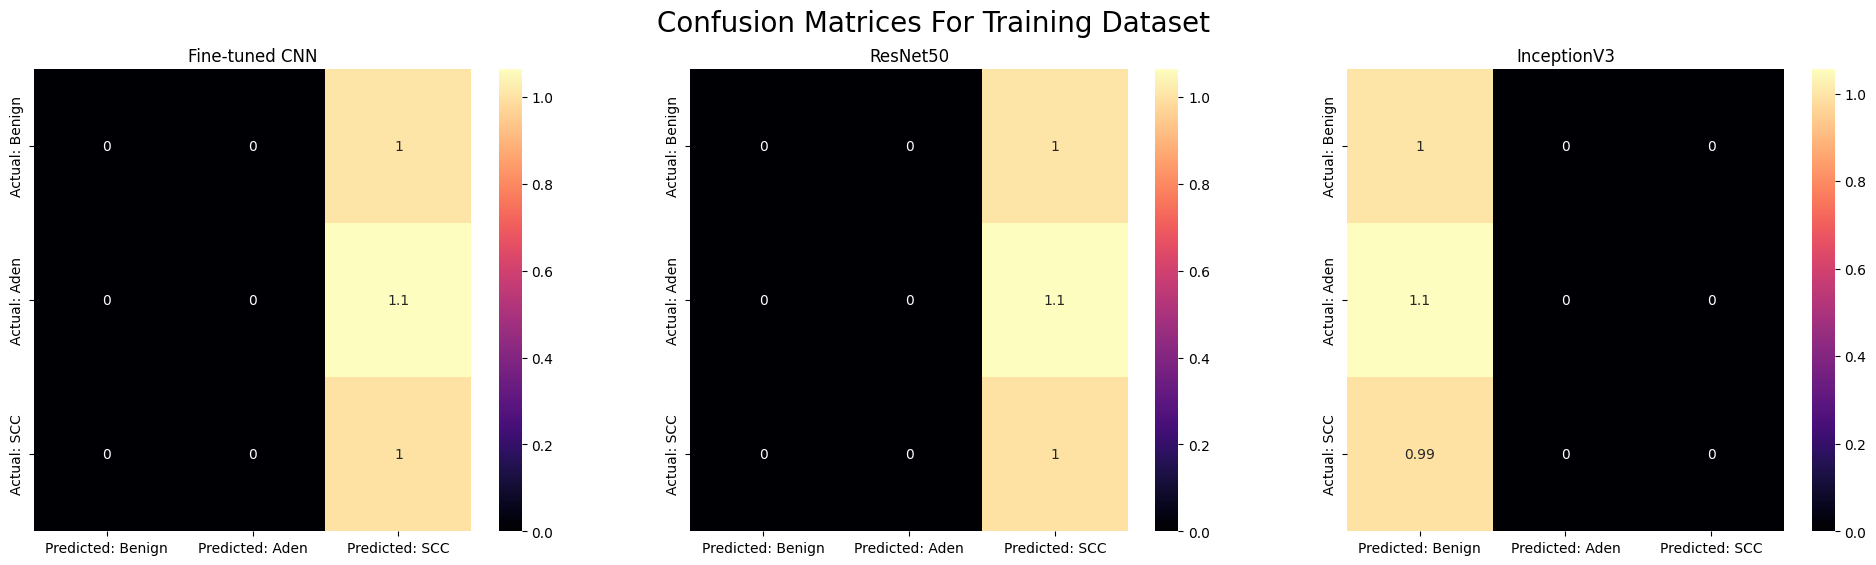

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,6))
fig.suptitle('Confusion Matrices For Training Dataset', fontsize=20)
axes[0].set_title('Fine-tuned CNN')
axes[1].set_title('ResNet50')
axes[2].set_title('InceptionV3')
display_conf_matrix(cm_train_CNN, axes[0])
display_conf_matrix(cm_train_ResNet50V2, axes[1])
display_conf_matrix(cm_train_InceptionV3, axes[2])
plt.show()

**Figure 12** - The confusion matrices for the training dataset of the fine-tuned CNN model, ResNet50 model and InceptionV3 model.

**5.2.2 Display confusion matrices for the validation dataset**

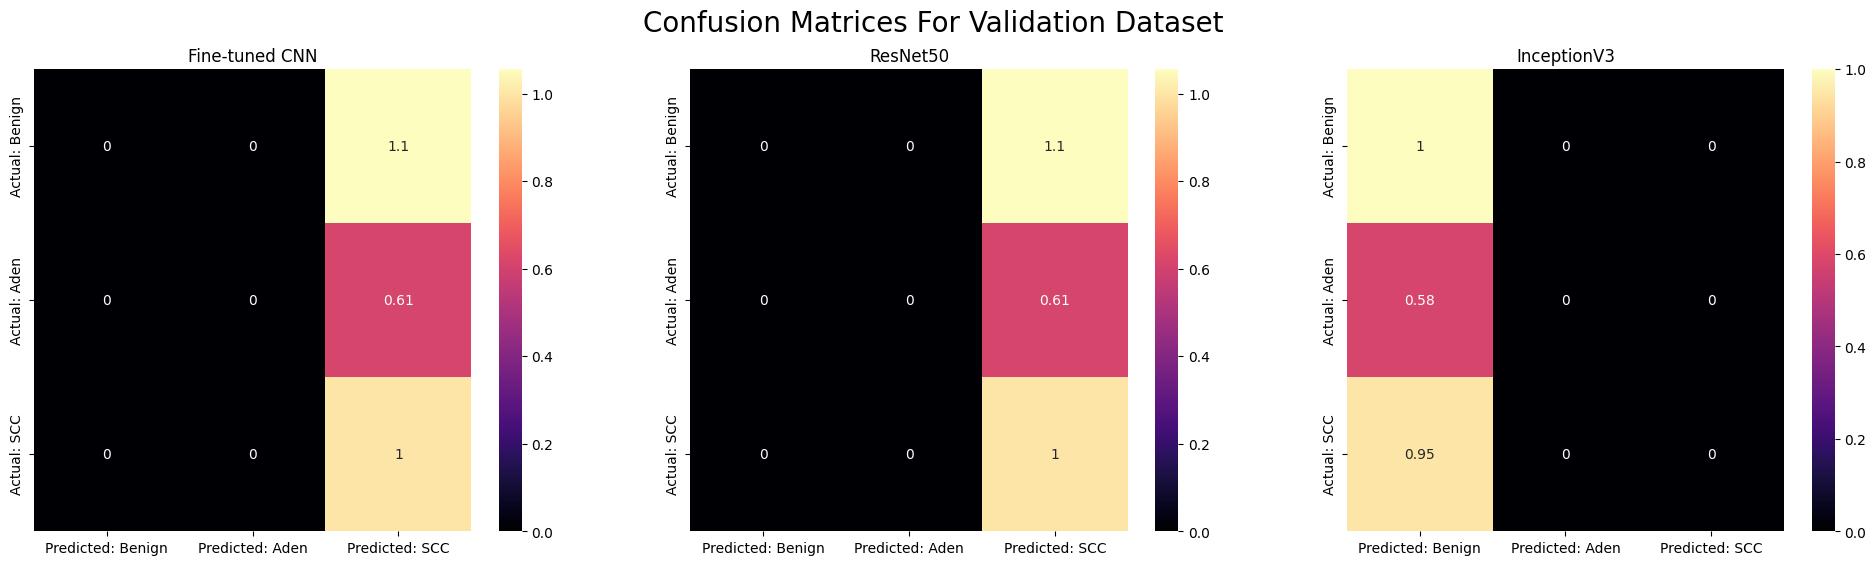

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,6))
fig.suptitle('Confusion Matrices For Validation Dataset', fontsize=20)
axes[0].set_title('Fine-tuned CNN')
axes[1].set_title('ResNet50')
axes[2].set_title('InceptionV3')
display_conf_matrix(cm_valid_CNN, axes[0])
display_conf_matrix(cm_valid_ResNet50V2, axes[1])
display_conf_matrix(cm_valid_InceptionV3, axes[2])
plt.show()

**Figure 13** - The confusion matrices for the validation dataset of the fine-tuned CNN model, ResNet50 model and InceptionV3 model.

**5.3 Accuracy, precision, recall and f1 scores**

In [ ]:
#Calculates accuracy, precision, recall, f1 and specificity from predicted and true results
def calc_scores(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Calculate accuracy score
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision score
  precision = precision_score(y_true, y_pred, average='weighted')

  # Calculate recall score
  recall = recall_score(y_true, y_pred, average='weighted')

  # Calculate f1 score
  f1 = f1_score(y_true, y_pred, average='weighted')

  return [accuracy, precision, recall, f1]

In [ ]:
#Define the accuracy, precision, recall and f1 scores of each model for the training dataset
scores_train_CNN = calc_scores(CNN_model, X_train, y_train)
scores_train_ResNet50V2 = calc_scores(ResNe50V2_model, X_train, y_train)
scores_train_InceptionV3 = calc_scores(InceptionV3_model, X_train, y_train)

#Define the accuracy, precision, recall and f1 scores of each model for the validation dataset
scores_valid_CNN = calc_scores(CNN_model, X_valid, y_valid)
scores_valid_ResNet50V2 = calc_scores(ResNe50V2_model, X_valid, y_valid)
scores_valid_InceptionV3 = calc_scores(InceptionV3_model, X_valid, y_valid)

12/12 [==============================] - 1s 46ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 110ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 88ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 110ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Define the model names and their scores for both training and validation set
models = {'Fine-tuned CNN' : {'Accuracy (Train)' : scores_train_CNN[0],
                  'Accuracy (Valid)' : scores_valid_CNN[0],
                   'Precision (Train)' : scores_train_CNN[1],
                   'Precision (Valid)' : scores_valid_CNN[1],
                   'Recall (Train)' : scores_train_CNN[2],
                  'Recall (Valid)' : scores_valid_CNN[2],
                   'F1 (Train)' : scores_train_CNN[3],
                   'F1 (Valid)' : scores_valid_CNN[3]
                   },
          'ResNet50V2' : {'Accuracy (Train)' : scores_train_ResNet50V2[0],
                  'Accuracy (Valid)' : scores_valid_ResNet50V2[0],
                   'Precision (Train)' : scores_train_ResNet50V2[1],
                   'Precision (Valid)' : scores_valid_ResNet50V2[1],
                   'Recall (Train)' : scores_train_ResNet50V2[2],
                  'Recall (Valid)' : scores_valid_ResNet50V2[2],
                   'F1 (Train)' : scores_train_ResNet50V2[3],
                   'F1 (Valid)' : scores_valid_ResNet50V2[3]
                   },
          'InceptionV3' : {'Accuracy (Train)' : scores_train_InceptionV3[0],
                  'Accuracy (Valid)' : scores_valid_InceptionV3[0],
                   'Precision (Train)' : scores_train_InceptionV3[1],
                   'Precision (Valid)' : scores_valid_InceptionV3[1],
                   'Recall (Train)' : scores_train_InceptionV3[2],
                  'Recall (Valid)' : scores_valid_InceptionV3[2],
                   'F1 (Train)' : scores_train_InceptionV3[3],
                   'F1 (Valid)' : scores_valid_InceptionV3[3]
                   }
          }
#Create a dataframe table of the dictionary of the models
scores = pd.DataFrame(models).T
scores

,Accuracy (Train),Accuracy (Valid),Precision (Train),Precision (Valid),Recall (Train),Recall (Valid),F1 (Train),F1 (Valid)
Fine-tuned CNN,0.325521,0.375000,0.105964,0.140625,0.325521,0.375000,0.159883,0.204545
ResNet50V2,0.325521,0.375000,0.105964,0.140625,0.325521,0.375000,0.159883,0.204545
InceptionV3,0.328125,0.395833,0.107666,0.156684,0.328125,0.395833,0.162132,0.224502


**Table 2** - The accuracy, precision, recall and f1-scores for the training and validation dataset of the fine-tuned CNN model, ResNet50 V2 model and the Inception V3 model.

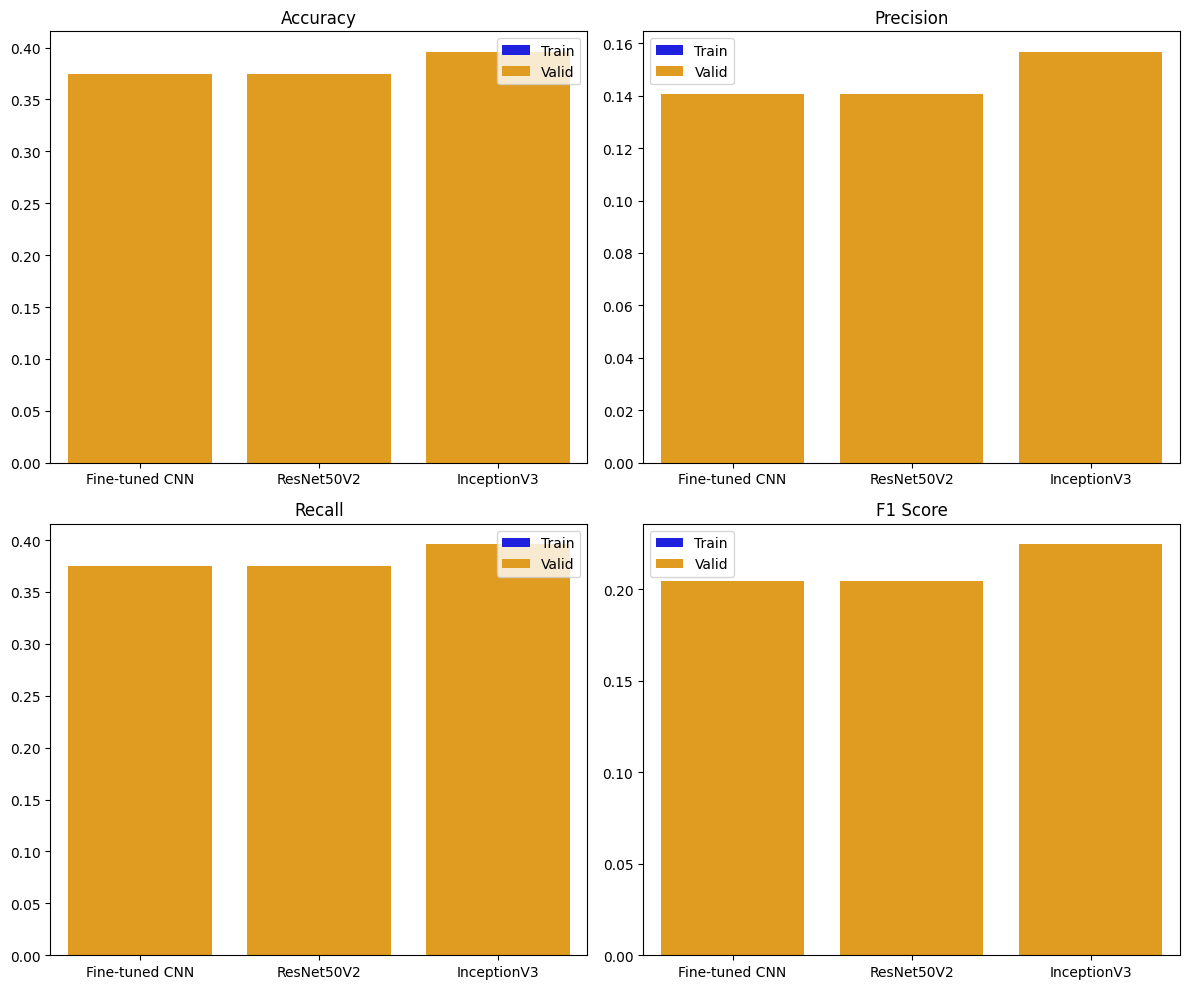

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Define models
models = scores.index

# Bar plot for Accuracy
sns.barplot(x=models, y='Accuracy (Train)', data=scores, ax=axes[0,0], color='blue', label='Train')
sns.barplot(x=models, y='Accuracy (Valid)', data=scores, ax=axes[0,0], color='orange', label='Valid')
axes[0,0].set_title('Accuracy')
axes[0,0].set(ylabel=None)
axes[0,0].legend()

# Bar plot for Precision
sns.barplot(x=models, y='Precision (Train)', data=scores, ax=axes[0,1], color='blue', label='Train')
sns.barplot(x=models, y='Precision (Valid)', data=scores, ax=axes[0,1], color='orange', label='Valid')
axes[0,1].set_title('Precision')
axes[0,1].set(ylabel=None)
axes[0,1].legend()

# Bar plot for Recall
sns.barplot(x=models, y='Recall (Train)', data=scores, ax=axes[1,0], color='blue', label='Train')
sns.barplot(x=models, y='Recall (Valid)', data=scores, ax=axes[1,0], color='orange', label='Valid')
axes[1,0].set_title('Recall')
axes[1,0].set(ylabel=None)
axes[1,0].legend()

# Bar plot for F1 Score
sns.barplot(x=models, y='F1 (Train)', data=scores, ax=axes[1,1], color='blue', label='Train')
sns.barplot(x=models, y='F1 (Valid)', data=scores, ax=axes[1,1], color='orange', label='Valid')
axes[1,1].set_title('F1 Score')
axes[1,1].set(ylabel=None)
axes[1,1].legend()

# Adjust layout
plt.tight_layout()

plt.show()

**Figure 14** - The graph of accuracy, precision, recall and f1-score for the training and validation dataset for the fine-tuned CNN model, ResNet50V2 and InceptionV3 models.

**5.4 Training Time**

In [ ]:
# Define the model names and their time for training
models = {'Fine-Tuned CNN' : {'Training Time (seconds)' : CNN_training_time},
          'ResNet50V2' : {'Training Time (seconds)' : ResNet50V2_training_time},
          'InceptionV3' : {'Training Time (seconds)' : InceptionV3_training_time}
          }
#Create a dataframe table of the dictionary of the models ad their time
times = pd.DataFrame(models).T
times

,Training Time (seconds)
Fine-Tuned CNN,1.224009
ResNet50V2,40.513940
InceptionV3,47.778187


**Table 3** - The time required to train a fine-tuned CNN model, a ResNet50V2 model, and an InceptionV3 model. The table shows how time-consuming fine-tuning a CNN model is, with the time being more than three times that of the transfer learning method.

**5.5 Analysis Of The Methods**

**5.5.1 Fine-tuning a Large-Scale CNN Model**

Convolutional Neural Networks (CNNs) are particularly effective for medical image processing, such as detecting lung cancer in CT scans. The reason being is that they consists of several convolutional layers. These layers learn hierarchical characteristics from the input images automatically, capturing spatial patterns and local structures. They also consists of pooling layers which reduces computational complexity while preserving vital information by downsampling the spatial dimensions of the feature maps. Furthermore, they use activation functions such as Rectified Linear Unit (ReLU) after each convolutional layer, to add non-linearity to the model. CNNs learn hierarchical feature representations, starting with low-level features such as edges and textures and continuing to high-level features such as complex structures and patterns. The model can recognise features at different sizes because of the convolutional and pooling processes, which allow it to record spatial hierarchies.

However, CNNs are primarily built for image data and may not be ideal for tasks requiring understanding temporal connections, which may be important in certain areas of lung cancer diagnosis. Furthermore, as shown in Table 3, training large-scale image models and fine-tuning their hyperparamters is time and energy-consuming.

**5.5.2 Transfer Learning Using a ResNet50 Model**

Since most vision datasets have some common features, it is possible to take a network trained on a similar dataset and use the trained features to reduce training time on a different dataset. This is where transfer learning can be useful when time efficiency is at most an important asset.

One of the main advantages of the ResNet50 model is that it introduces the concept of residual learning, which aids in the reduction of the vanishing gradient problem. This allows the model to capture detailed features in CT scans by training incredibly deep networks. ResNet50 is also pre-trained on large-scale image datasets. Transfer learning is useful for leveraging these weights, especially when dealing with limited labeled medical data. The pre-trained weights function as a feature extractor, which improves model generalization. Furthermore, ResNet50 has outperformed other picture categorization algorithms. The deep design aids with understanding hierarchical characteristics, which is critical for spotting tiny patterns in CT scans that indicate lung cancer.

Despite these advantages however, the deep architecture of ResNet50 can be computationally demanding, necessitating significant computing resources for training and inference. This may present difficulties in resource-constrained contexts, as seen in this project. Overfitting is a problem in medical imaging applications with minimal labeled data, especially when utilizing complicated models like ResNet50. To mitigate this danger, proper regularization approaches, such as dropout, are required.

**5.5.3 Transfer Leaning Using an InceptionV3 Model**

As mentioned in Chapter 4, the Inception V1 and V3 models employs the concept of using many filters of varying sizes on the same level which prevents an overfit. Furthermore, the use of an auxiliary classifier is intended to improve the convergence of very deep neural networks. In very deep networks, the auxiliary classifier is primarily used to tackle the vanishing gradient problem. In the early stages of training, the auxiliary classifiers did not result in any improvement. But in the end, networks with auxiliary classifiers outperformed the network without auxiliary classifiers (Szegedy, C., Vanhoucke, V., Ioffe, S., & Shlens, J. n.d.).

The performance of InceptionV3 is sensitive to hyperparameters, and determining the best configuration may necessitate additional effort. It is critical to fine-tune the learning rate, regularization parameters, and dropout rates to achieve the optimum results. While InceptionV3 excels at capturing characteristics at many sizes, it may be limited when processing extremely high-resolution pictures, such as those present in some CT scans.

# Conclusion

Transfer learning and fine-tuning are useful techniques in image classification with CNNs. Transfer learning improves efficiency, performance, and domain adaptation, whereas fine-tuning provides for customization and control over the training process. With fine-tuning, we have demonstrated that the CNN model can produce accurate detection with our CT images in comparison with our pre-trained models but with longer training time. Through transfer learning, both ResNet50V2 and InceptionV3 demonstrate promising capability for lung cancer identification in CT scans. The decision between them depends on factors such as available computational resources, time for training, dataset size, and the desired balance of computational efficiency and model accuracy. These factors must be carefully considered, together with suitable hyperparameter tuning and regularisation, in order to optimize the performance of these models in the specific context of lung cancer detection in CT scans.






# References

1. Lung and Colon Cancer Histopathological Images. (n.d.). www.kaggle.com. Retrieved November 10, 2023, from https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

2. American Cancer Society. What Is Lung Cancer? | Types of Lung Cancer. (January 12, 2023). www.cancer.org. https://www.cancer.org/cancer/types/lung-cancer/about/what-is.html#:~:text=Adenocarcinoma%3A%20Adenocarcinomas%20start%20in%20the

3. Human Centered Computing: 5th International Conference, HCC 2019, Čačak, Serbia, August 5–7, 2019, Revised Selected Papers. (2020). Germany: Springer International Publishing.

4. Sreenivasu, S. V. N., Gomathi, S., Kumar, M. J., Prathap, L., Madduri, A., Almutairi, K. M. A., Alonazi, W. B., Kali, D., & Jayadhas, S. A. (2022). Dense Convolutional Neural Network for Detection of Cancer from CT Images. BioMed Research International, 2022, e1293548. https://doi.org/10.1155/2022/1293548

5. ResNet-50: The Basics and a Quick Tutorial. (n.d.). Datagen. https://datagen.tech/guides/computer-vision/resnet-50/

6. He, K., Zhang, X., Ren, S., & Sun, J. (2016). Identity Mappings in Deep Residual Networks. Computer Vision – ECCV 2016, 630–645. https://doi.org/10.1007/978-3-319-46493-0_38

7. f.keras.applications.resnet50.preprocess_input | TensorFlow v2.11.0. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input

8. Mukherjee, S. (2022, August 18). The Annotated ResNet-50. Medium. https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758

9. Team, K. (2020, April 15). Keras documentation: Transfer learning & fine-tuning. Keras.io. https://keras.io/guides/transfer_learning/

10. Szegedy, C., Vanhoucke, V., Ioffe, S., & Shlens, J. (n.d.). Rethinking the Inception Architecture for Computer Vision. https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf